# Ordinal Encoding

In [70]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pandas as pd
import numpy as np

label_encoder = None 

def get_np_array(file_name):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OrdinalEncoder()
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

In [34]:
train_data = pd.read_csv('train.csv')
train_data.head()


,Unnamed: 0,team,opp,host,year,month,toss,day_match,bat_first,format,fow,score,rpo,result
0,4901,australia,south_africa,sri_lanka,2012,sep,1,0,0,1,5,146,7.30,1
1,1910,india,australia,india,2020,jan,0,0,1,0,6,340,6.80,1
2,5735,canada,scotland,scotland,2009,jul,1,1,0,0,4,286,5.72,1
3,2136,australia,england,australia,1987,jan,1,1,1,0,6,225,4.50,1
4,4371,new_zealand,pakistan,uae,2009,nov,0,0,0,1,5,153,7.65,0


In [35]:
X_train, y_train = get_np_array('train.csv')

# Printing the shape of the training data to verify its structure
X_train.shape, y_train.shape

((7827, 12), (7827, 1))

In [36]:
X_test, y_test = get_np_array('test.csv')

In [37]:
# Identifying which columns are continuous for the decision tree construction
types = ['cat', 'cat', 'cat', "cat", "cat", "cont", "cat", "cat", "cat", "cont", "cont", "cont"]
continuous_columns = [i for i, t in enumerate(types) if t == 'cont']


In [65]:
class DTNode:
    def __init__(self, depth, is_leaf=False, value=None, column=None, median=None):
        self.depth = depth
        self.is_leaf = is_leaf
        self.value = value
        self.column = column
        self.median = median
        self.children = {}

    def get_child(self, X):
        if self.is_leaf:
            return self

        feature_value = X[self.column]
        if self.column in continuous_columns:
            if feature_value > self.median:
                return self.children.get('right')
            else:
                return self.children.get('left')
        else:
            return self.children.get(feature_value)


class DTTree:
    def __init__(self):
        self.root = None

    def fit(self, X, y, types, max_depth=10):
        self.root = self._fit_recursive(X, y, depth=0, max_depth=max_depth, types=types)

    def _fit_recursive(self, X, y, depth, max_depth, types):
        if depth == max_depth or len(np.unique(y)) == 1:
            return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))

        best_feature, best_median = self._find_best_split(X, y, types)
        if best_feature is None:
            return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))

        node = DTNode(depth, column=best_feature, median=best_median)
        if types[best_feature] == 'cont':
            left_indices = X[:, best_feature] <= best_median
            right_indices = X[:, best_feature] > best_median
            if sum(left_indices) == 0:
                return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))
            if sum(right_indices) == 0:
                return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))
            node.children['left'] = self._fit_recursive(X[left_indices], y[left_indices], depth+1, max_depth, types)
            node.children['right'] = self._fit_recursive(X[right_indices], y[right_indices], depth+1, max_depth, types)
        else:
            unique_values = np.unique(X[:, best_feature])
            for value in unique_values:
                indices = X[:, best_feature] == value
                node.children[value] = self._fit_recursive(X[indices], y[indices], depth+1, max_depth, types)

        if not node.children:
            return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))
        
        return node

    def _find_best_split(self, X, y, types):
        best_feature = None
        best_median = None
        best_mutual_info = -np.inf

        for feature in range(X.shape[1]):
            if types[feature] == 'cont':
                median = np.median(X[:, feature])
                left = y[X[:, feature] <= median]
                right = y[X[:, feature] > median]
                mutual_info = self._calculate_mutual_information(y, left, right)
            else:
                mutual_info = self._calculate_mutual_information(y, *[y[X[:, feature] == value] for value in np.unique(X[:, feature])])

            if mutual_info > best_mutual_info:
                best_mutual_info = mutual_info
                best_feature = feature
                best_median = median if types[feature] == 'cont' else None

        return best_feature, best_median

    def _calculate_mutual_information(self, y, *splits):
        total_count = sum(split.size for split in splits)
        entropy_before = self._calculate_entropy(y)
        entropy_after = sum(self._calculate_entropy(split) * split.size / total_count for split in splits)
        return entropy_before - entropy_after

    @staticmethod
    def _calculate_entropy(y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def predict(self, X):
        predictions = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            node = self.root
            while not node.is_leaf:
                child = node.get_child(X[i])
                if child is None:
                    break
                node = child
            predictions[i] = node.value
        return predictions.reshape(-1, 1)

    def post_prune(self, X_val, y_val):
        # TODO: Implement post-pruning
        pass


# Creating the decision tree and fitting it to the training data
tree = DTTree()
tree.fit(X_train, y_train, types, max_depth=10)

# Predicting the test set labels using the trained decision tree
y_pred_test = tree.predict(X_test)

# Calculating the accuracy on the test set
test_accuracy = np.mean(y_pred_test == y_test)
test_accuracy

0.6215098241985523

In [39]:
# Calculate Training Accuracy
y_pred_train = tree.predict(X_train)
train_accuracy = np.mean(y_pred_train == y_train)
train_accuracy

0.9962948767088284

In [40]:
depths = [5, 10, 15, 20, 25]
model_of_depth = {}
training_accuracies = []
test_accuracies = []

for depth in depths:
    tree = DTTree()
    tree.fit(X_train, y_train, types, max_depth=depth)
    model_of_depth[depth] = tree
    
    # Print Training and Test accuracies
    y_pred_train = tree.predict(X_train)
    train_accuracy = np.mean(y_pred_train == y_train)
    print("Training Accuracy for depth", depth, ":", train_accuracy)
    training_accuracies.append(train_accuracy)
    
    y_pred_test = tree.predict(X_test)
    test_accuracy = np.mean(y_pred_test == y_test)
    print("Test Accuracy for depth", depth, ":", test_accuracy)
    test_accuracies.append(test_accuracy)

Training Accuracy for depth 5 : 0.8855244665900089
Test Accuracy for depth 5 : 0.5439503619441571
Training Accuracy for depth 10 : 0.9962948767088284
Test Accuracy for depth 10 : 0.5656670113753878
Training Accuracy for depth 15 : 0.9969336910693752
Test Accuracy for depth 15 : 0.5656670113753878
Training Accuracy for depth 20 : 0.9969336910693752
Test Accuracy for depth 20 : 0.5656670113753878
Training Accuracy for depth 25 : 0.9969336910693752
Test Accuracy for depth 25 : 0.5656670113753878


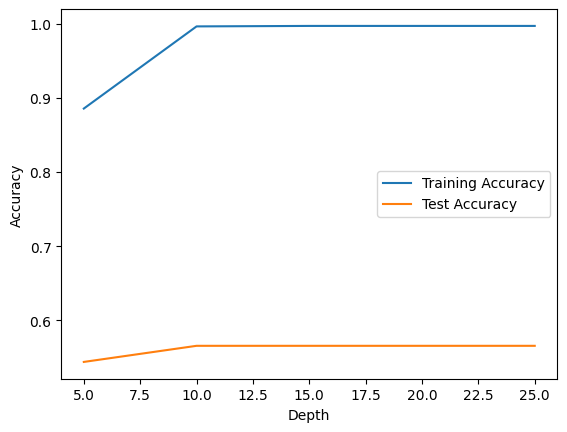

In [41]:
# plot the accuracies vs depths

import matplotlib.pyplot as plt

plt.plot(depths, training_accuracies, label="Training Accuracy")
plt.plot(depths, test_accuracies, label="Test Accuracy")

plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("(a)depth_vs_accuracy.png")
plt.show()

In [42]:
# Accuracy for only win and only loss prediction
y_pred_train_loss = np.zeros(y_train.shape)
y_pred_train_win = np.ones(y_train.shape)

y_pred_test_loss = np.zeros(y_test.shape)
y_pred_test_win = np.ones(y_test.shape)

train_accuracy_loss = np.mean(y_pred_train_loss == y_train)
train_accuracy_win = np.mean(y_pred_train_win == y_train)

test_accuracy_loss = np.mean(y_pred_test_loss == y_test)
test_accuracy_win = np.mean(y_pred_test_win == y_test)

print("Training Accuracy for only loss prediction:", train_accuracy_loss)
print("Training Accuracy for only win prediction:", train_accuracy_win)

print("Test Accuracy for only loss prediction:", test_accuracy_loss)
print("Test Accuracy for only win prediction:", test_accuracy_win)


Training Accuracy for only loss prediction: 0.49661428388910184
Training Accuracy for only win prediction: 0.5033857161108982
Test Accuracy for only loss prediction: 0.5036194415718718
Test Accuracy for only win prediction: 0.4963805584281282


# One Hot Encoding

In [43]:
label_encoder = None

def get_np_array_one_hot(file_name):
    global label_encoder
    data = pd.read_csv(file_name)
    
    need_label_encoding = ['team','host','opp','month', 'day_match']
    if(label_encoder is None):
        label_encoder = OneHotEncoder(sparse_output=False)
        label_encoder.fit(data[need_label_encoding])
    data_1 = pd.DataFrame(label_encoder.transform(data[need_label_encoding]), columns = label_encoder.get_feature_names_out())
    
    #merge the two dataframes
    dont_need_label_encoding =  ["year","toss","bat_first","format" ,"fow","score" ,"rpo" ,"result"]
    data_2 = data[dont_need_label_encoding]
    final_data = pd.concat([data_1, data_2], axis=1)
    
    X = final_data.iloc[:,:-1]
    y = final_data.iloc[:,-1:]
    return X.to_numpy(), y.to_numpy()

In [44]:
# Loading the one-hot encoded training and test data
X_train_one_hot, y_train_one_hot = get_np_array_one_hot('train.csv')
X_test_one_hot, y_test_one_hot = get_np_array_one_hot('test.csv')

# Displaying the shapes of the one-hot encoded datasets
X_train_one_hot.shape, y_train_one_hot.shape, X_test_one_hot.shape, y_test_one_hot.shape

((7827, 79), (7827, 1), (967, 79), (967, 1))

In [54]:
y_train_one_hot[:10]

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1]])

In [45]:
# # Revisiting the decision tree implementation and accuracy calculation
# 
# class DTNode:
# 
#     def __init__(self, depth, is_leaf=False, value=None, column=None, split_value=None):
#         self.depth = depth
#         self.is_leaf = is_leaf
#         self.value = value
#         self.column = column
#         self.split_value = split_value
#         self.children = {}
# 
#     def add_child(self, value, node):
#         self.children[value] = node
# 
# class DTTree:
# 
#     def __init__(self):
#         self.root = None
# 
#     def fit(self, X, y, types, max_depth=10):
#         self.root = self._fit_recursive(X, y, 0, max_depth, types)
# 
#     def _fit_recursive(self, X, y, depth, max_depth, types):
#         if depth == max_depth or len(np.unique(y)) == 1:
#             return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))
# 
#         best_gain = -1
#         best_column = None
#         best_split_value = None
#         best_sets = None
# 
#         for i in range(X.shape[1]):
#             column_values = X[:, i]
#             unique_values = np.unique(column_values)
# 
#             for value in unique_values:
#                 left_indices = column_values <= value
#                 right_indices = column_values > value
# 
#                 if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
#                     continue
# 
#                 left_y = y[left_indices]
#                 right_y = y[right_indices]
# 
#                 gain = self.information_gain(y, left_y, right_y)
#                 if gain > best_gain:
#                     best_gain = gain
#                     best_column = i
#                     best_split_value = value
#                     best_sets = (X[left_indices], y[left_indices], X[right_indices], y[right_indices])
# 
#         if best_gain == -1:
#             return DTNode(depth, is_leaf=True, value=np.argmax(np.bincount(y.flatten())))
# 
#         left_node = self._fit_recursive(*best_sets[:2], depth + 1, max_depth, types)
#         right_node = self._fit_recursive(*best_sets[2:], depth + 1, max_depth, types)
#         node = DTNode(depth, column=best_column, split_value=best_split_value)
#         node.add_child("left", left_node)
#         node.add_child("right", right_node)
# 
#         return node
# 
#     def information_gain(self, parent, left_child, right_child):
#         def entropy(y):
#             unique, counts = np.unique(y, return_counts=True)
#             probabilities = counts / counts.sum()
#             return -np.sum(probabilities * np.log2(probabilities))
# 
#         parent_entropy = entropy(parent)
#         left_entropy = entropy(left_child)
#         right_entropy = entropy(right_child)
# 
#         left_weight = len(left_child) / len(parent)
#         right_weight = len(right_child) / len(parent)
# 
#         return parent_entropy - (left_weight * left_entropy + right_weight * right_entropy)
# 
#     def predict(self, X):
#         predictions = []
#         for i in range(X.shape[0]):
#             node = self.root
#             while not node.is_leaf:
#                 value = X[i, node.column]
#                 if value <= node.split_value:
#                     node = node.children["left"]
#                 else:
#                     node = node.children["right"]
#             predictions.append(node.value)
#         return np.array(predictions)

In [46]:

# Function to calculate accuracy
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

In [48]:
# Identifying which columns are continuous for the decision tree construction
types = ["cont"] * X_train_one_hot.shape[1]
continuous_columns = [i for i, t in enumerate(types) if t == 'cont']

In [53]:
continuous_columns

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78]

In [66]:
# Fitting and evaluating the decision tree for different maximum depths
depths = [15, 25, 35, 45]
results_one_hot_corrected = []
model_of_depth_one_hot = {}

for max_depth in depths:
    print("Max Depth:", max_depth)
    tree = DTTree()
    tree.fit(X_train_one_hot, y_train_one_hot, types=["cont"] * X_train_one_hot.shape[1], max_depth=max_depth)
    y_pred_train = tree.predict(X_train_one_hot)
    y_pred_test = tree.predict(X_test_one_hot)
    train_accuracy = calculate_accuracy(y_train_one_hot, y_pred_train)
    test_accuracy = calculate_accuracy(y_test_one_hot, y_pred_test)
    results_one_hot_corrected.append((max_depth, train_accuracy, test_accuracy))
    
    model_of_depth_one_hot[max_depth] = tree
    
    print("Training Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)

Max Depth: 15
Training Accuracy: 0.7021847451130702
Test Accuracy: 0.5573940020682523
Max Depth: 25
Training Accuracy: 0.8397853583748562
Test Accuracy: 0.6039296794208894
Max Depth: 35
Training Accuracy: 0.923342276734381
Test Accuracy: 0.5925542916235781
Max Depth: 45
Training Accuracy: 0.9868404241727354
Test Accuracy: 0.6059979317476732


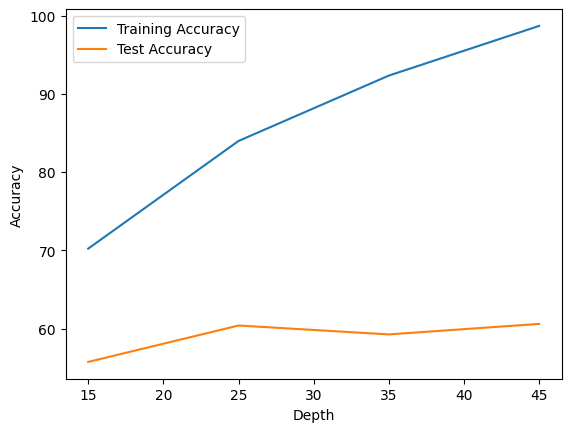

In [68]:
# plot the results

plt.plot(depths, [r[1]*100 for r in results_one_hot_corrected], label="Training Accuracy")
plt.plot(depths, [r[2]*100 for r in results_one_hot_corrected], label="Test Accuracy")

plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("(b)depth_vs_accuracy.png")
plt.show()

# Scikit Learn Decision Tree

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

X_train, y_train = get_np_array('train.csv')
X_test, y_test = get_np_array('test.csv')
X_val, y_val = get_np_array('val.csv')

# Evaluate the decision tree for different max depths
depths = [15, 25, 35, 45]
dt_results = []

for depth in depths:
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    dt_clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, dt_clf.predict(X_train))
    test_acc = accuracy_score(y_test, dt_clf.predict(X_test))
    val_acc = accuracy_score(y_val, dt_clf.predict(X_val))
    
    dt_results.append((depth, train_acc, test_acc, val_acc))

dt_results_df = pd.DataFrame(dt_results, columns=['Max Depth', 'Training Accuracy', 'Test Accuracy', 'Validation Accuracy'])
print(dt_results_df)

   Max Depth  Training Accuracy  Test Accuracy  Validation Accuracy
0         15           0.824709       0.609100             0.641379
1         25           0.988374       0.634953             0.624138
2         35           1.000000       0.632885             0.625287
3         45           1.000000       0.629783             0.620690


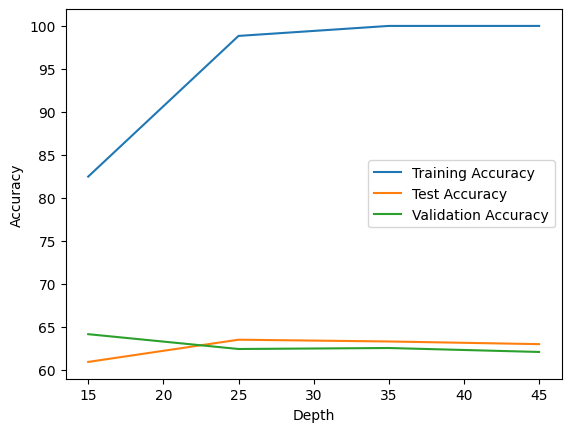

In [91]:
# plot the results

plt.plot(depths, [r[1]*100 for r in dt_results], label="Training Accuracy")
plt.plot(depths, [r[2]*100 for r in dt_results], label="Test Accuracy")
plt.plot(depths, [r[3]*100 for r in dt_results], label="Validation Accuracy")

plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("(d)depth_vs_accuracy.png")
plt.show()

In [98]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


X_val, y_val = get_np_array('val.csv')

# Evaluate the decision tree for different max depths
ccp_values = [0.001, 0.01, 0.1, 0.2]
dt_results = []

for ccp in ccp_values:
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=15, ccp_alpha=ccp)
    dt_clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, dt_clf.predict(X_train))
    test_acc = accuracy_score(y_test, dt_clf.predict(X_test))
    val_acc = accuracy_score(y_val, dt_clf.predict(X_val))
    
    dt_results.append((ccp, train_acc, test_acc, val_acc))

# Output the results in a structured format
dt_results_df = pd.DataFrame(dt_results, columns=['CCP', 'Training Accuracy', 'Test Accuracy', 'Validation Accuracy'])
print(dt_results_df)

     CCP  Training Accuracy  Test Accuracy  Validation Accuracy
0  0.001           0.684426       0.622544             0.636782
1  0.010           0.534432       0.518097             0.500000
2  0.100           0.503386       0.496381             0.473563
3  0.200           0.503386       0.496381             0.473563


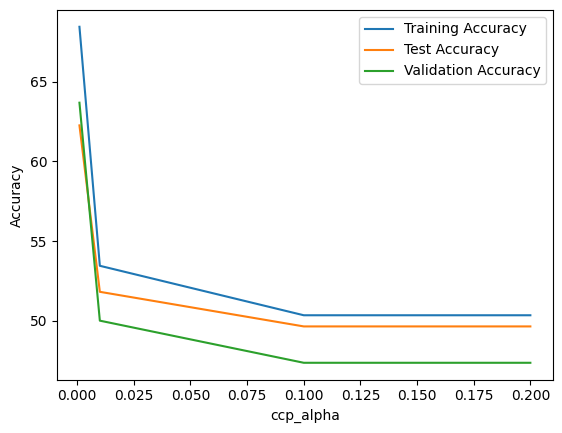

In [99]:
# plot the results

plt.plot(ccp_values, [r[1]*100 for r in dt_results], label="Training Accuracy")
plt.plot(ccp_values, [r[2]*100 for r in dt_results], label="Test Accuracy")
plt.plot(ccp_values, [r[3]*100 for r in dt_results], label="Validation Accuracy")

plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("(d)ccp_vs_accuracy.png")
plt.show()

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd


param_grid_rf = {
    'n_estimators': [50, 150, 250, 350],
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
    'min_samples_split': [2, 4, 6, 8, 10]
}

rf_clf = RandomForestClassifier(oob_score=True, random_state=43)

grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, scoring='accuracy')

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train.ravel())

# Extract the best estimator
best_rf_clf = grid_search_rf.best_estimator_

# Predict on training, validation and test sets with the best estimator
y_train_pred_rf = best_rf_clf.predict(X_train)
y_val_pred_rf = best_rf_clf.predict(X_val)
y_test_pred_rf = best_rf_clf.predict(X_test)

# Calculate accuracies
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

# OOB accuracy
oob_accuracy_rf = best_rf_clf.oob_score_

# Best parameters
best_params_rf = grid_search_rf.best_params_

# Compile the results
random_forest_results = {
    'Best Parameters': best_params_rf,
    'OOB Accuracy': oob_accuracy_rf,
    'Training Accuracy': train_accuracy_rf,
    'Validation Accuracy': val_accuracy_rf,
    'Test Accuracy': test_accuracy_rf
}

# Print the results
print(random_forest_results)

{'Best Parameters': {'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 350}, 'OOB Accuracy': 0.7281206081512712, 'Training Accuracy': 0.9457007793535198, 'Validation Accuracy': 0.7229885057471265, 'Test Accuracy': 0.7280248190279214}
